In [3]:
import os

In [4]:
working_dir = os.path.dirname(os.getcwd())
os.chdir(working_dir)

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd

d:\Application\Conda\envs\geoneuro\lib\site-packages\geopandas\_compat.py:153: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\Cover\AppData\Local\Temp\ipykernel_4892\1960879352.py:3: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


## Read the dataset

### For the survey users

In [6]:
# file `chain_pro_new_plus_tc.csv` comes from the tda life circle research project:
# R\202204_project_community_tda\preprocessing\nova_version_individual\process_individual.ipynb
# the file comes from chain_pro_new_plus.csv, which undergone the travel chaining process of tc module.
sourcefile = 'chain_pro_new_plus_tc.csv'
readpath = './data/'
writepath = './data/'

In [7]:
df = pd.read_csv(readpath + sourcefile)
df.t_start, df.t_end = pd.to_datetime(df.t_start), pd.to_datetime(df.t_end)

In [8]:
df

,pid,t_start,t_end,poi_id,longitude,latitude,X,Y,ptype
0,1102234,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,194414.951879,2.507883e+06,1
1,1102234,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,197403.987064,2.512234e+06,2
2,1102234,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,194911.187574,2.508235e+06,0
3,1102234,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,194256.862442,2.508485e+06,0
4,1102234,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,197403.987064,2.512234e+06,2
...,...,...,...,...,...,...,...,...,...
7644,102181433,2023-12-22 18:39:10,2023-12-22 19:08:35,7,113.967361,22.586105,188167.740968,2.500875e+06,0
7645,102181433,2023-12-22 19:16:44,2023-12-22 23:28:44,4,113.992081,22.593155,190726.937740,2.501604e+06,0
7646,102181433,2023-12-22 23:29:04,2023-12-25 14:39:53,0,113.973390,22.594425,188806.743693,2.501784e+06,1
7647,102181433,2023-12-25 15:04:38,2023-12-31 21:31:20,0,113.973390,22.594425,188806.743693,2.501784e+06,1


In [9]:
def split_by_midnight(row):
    row = row.copy()
    start = row.t_start
    end = row.t_end
    if start.date() == end.date():
        rows = [row]
    else:
        # compute the date difference in days
        timedelta = end.date() - start.date()
        count = timedelta.days + 1
        date_range = pd.date_range(start.date(), end.date(), freq='D')[1:]
        vconcat = pd.concat([row] * count, axis=1).T
        vconcat.t_start = [start] + list(date_range)
        vconcat.t_end = list(date_range) + [end]
        # dataframe to list of rows
        rows = [r for _, r in vconcat.iterrows()]
    return rows

ans = df.apply(split_by_midnight, axis=1)
df = pd.concat(ans.explode().tolist(), axis=1).T.reset_index(drop=True)

In [10]:
df

,pid,t_start,t_end,poi_id,longitude,latitude,X,Y,ptype
0,1102234,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,194414.951879,2507882.981005,1
1,1102234,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,197403.987064,2512233.914594,2
2,1102234,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,194911.187574,2508234.840172,0
3,1102234,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.02504,22.655869,194256.862442,2508484.714036,0
4,1102234,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,197403.987064,2512233.914594,2
...,...,...,...,...,...,...,...,...,...
11258,102181433,2023-12-28 00:00:00,2023-12-29 00:00:00,0,113.97339,22.594425,188806.743693,2501783.83026,1
11259,102181433,2023-12-29 00:00:00,2023-12-30 00:00:00,0,113.97339,22.594425,188806.743693,2501783.83026,1
11260,102181433,2023-12-30 00:00:00,2023-12-31 00:00:00,0,113.97339,22.594425,188806.743693,2501783.83026,1
11261,102181433,2023-12-31 00:00:00,2023-12-31 21:31:20,0,113.97339,22.594425,188806.743693,2501783.83026,1


In [11]:
grids = gpd.read_file(readpath + 'ss_city_grid/ss_city_grid_by_cover.shp')
# lower the column name of the grids
grids.columns = grids.columns.str.lower()
# convert the fnid as the int
grids.fnid = grids.fnid.astype(int)
grids.chess_x = grids.chess_x.astype(int)
grids.chess_y = grids.chess_y.astype(int)

In [12]:
act_geo = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')
act_geo_match_grids = gpd.sjoin_nearest(act_geo, grids, how='left', distance_col='distance')

act_geo_match_grids['distance'].max() * 111 * 1e3

d:\Application\Conda\envs\geoneuro\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


164.76565968757484

In [13]:
act_match = pd.DataFrame(act_geo_match_grids.drop(columns=['index_right', 'distance', 'geometry']))

In [14]:
act_match.head()

,pid,t_start,t_end,poi_id,longitude,latitude,X,Y,ptype,fnid,chess_x,chess_y
0,1102234,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,194414.951879,2507882.981005,1,32600,113,91
1,1102234,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,197403.987064,2512233.914594,2,39038,125,109
2,1102234,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,194911.187574,2508234.840172,0,33316,115,93
3,1102234,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.02504,22.655869,194256.862442,2508484.714036,0,33671,113,94
4,1102234,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,197403.987064,2512233.914594,2,39038,125,109


### For the migration users

In [15]:
dataset = pd.read_csv(readpath + 'foood_mob_cover.csv')
dataset = dataset.assign(who = dataset.quitaz_1 * 8000 + dataset.quitaz_2)
dataset = dataset.assign(mean_dur = (dataset.mean_dur - 200) / 1e3 + 114,
                         std_dur = (dataset.std_dur - 200) / 1e3 + 114,
                         mean_volm = dataset.mean_volm / 10 + 22.65,
                         std_volm = dataset.std_volm / 10 + 22.65)
dataset.drop(columns = ['quitaz_1', 'quitaz_2'], inplace = True)
dataset.rename(columns = {'mean_dur': 'lambda_o', 'mean_volm': 'phi_o',
                          'std_dur': 'lambda_d', 'std_volm': 'phi_d',
                          'district_o': 'poi_o', 'district_d': 'poi_d',
                          }, inplace = True)
column_names = ['who', 'date', 'seiqd', 'mode', 'poi_o', 'poi_d', 'lambda_o', 'phi_o', 'lambda_d',
       'phi_d']

dataset = dataset.reindex(columns=column_names)
dataset.sort_values(by=['who', 'date', 'seiqd'], inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [16]:
dataset

,who,date,seiqd,mode,poi_o,poi_d,lambda_o,phi_o,lambda_d,phi_d
0,126272,20190101,1,1,0,3,113.833530,22.689639,113.798765,22.681593
1,126272,20190101,2,1,3,14,113.798765,22.681593,113.889444,22.773309
2,126272,20190101,3,1,14,11,113.889444,22.773309,113.923893,22.695130
3,126272,20190101,4,1,11,7,113.923893,22.695130,113.848284,22.687043
4,126272,20190102,1,1,2,9,113.845781,22.600001,113.823771,22.677155
...,...,...,...,...,...,...,...,...,...,...
515400,78623283,20191229,1,4,1,0,114.026728,22.678067,114.078506,22.545678
515401,78623283,20191229,2,4,0,1,114.078506,22.545678,114.026728,22.678067
515402,78623283,20191230,1,4,1,0,114.026728,22.678067,114.078506,22.545678
515403,78623283,20191230,2,4,0,1,114.078506,22.545678,114.026728,22.678067


In [17]:
usermig = pd.read_csv(readpath + 'user_migration_date.csv')
usermig.rename(columns = {'illian': 'who'}, inplace = True)
usermig.drop_duplicates(inplace=True)
usermig.set_index('who', inplace=True)

In [18]:
# usermig_location = pd.read_csv(readpath + 'user_migration_date_plus_location.csv')
# usermig_location.drop_duplicates(inplace=True)

In [19]:
def crossfinding(data):
    # for parallel computing
    import numpy as np
    import pandas as pd
    
    data = data.copy()
    data['poi_last'] = data.poi_d.shift(1)
    cross_different = data.poi_o != data.poi_last
    cross_differ_iloc, = np.where(cross_different)
    sector_list = []
    
    for i in range(len(cross_differ_iloc)):
        pos = cross_differ_iloc[i]
        if i + 1 < len(cross_differ_iloc):
            next_pos = cross_differ_iloc[i + 1]
            sector = data.iloc[pos:next_pos]
        else:
            sector = data.iloc[pos:]
            
        creater = pd.DataFrame(data={
            'poi_id': sector.poi_o,
            'longitude': sector.lambda_o,
            'latitude': sector.phi_o,
        })        
        create_tail = sector.iloc[-1:][['poi_d', 'lambda_d', 'phi_d']]
        create_tail.columns = ['poi_id', 'longitude', 'latitude']
        creater = pd.concat([creater, create_tail])
        sector_list.append(creater)
        
    return pd.concat(sector_list, axis=0, ignore_index=True)


In [20]:
from pandarallel import pandarallel
# pandarallel will determine how many cores you have, but you can specify it yourself
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [21]:
# pandas apply is too slow, we accelerate the computation with pandarallel
data_gathered = dataset.groupby(['who', 'date']).parallel_apply(crossfinding)
# or traditional pandas
# data_gathered = dataset.groupby(['who', 'date']).apply(crossfinding)

In [22]:
act_points = data_gathered.droplevel(2)
act_points.reset_index(inplace=True)

In [23]:
data = act_points.copy()
act_points = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']), crs=4326)

In [24]:
act_points = act_points.to_crs(32650)
act_points['X'] = act_points.geometry.x
act_points['Y'] = act_points.geometry.y

In [25]:
# remove the rows with missing values
# and add a sequence number for each record for each group
act_points.dropna(inplace=True)
act_points['seq'] = act_points.groupby(['who', 'date']).cumcount()

In [26]:
act_points = act_points.to_crs(4326)
act_geo_match_grids = gpd.sjoin_nearest(act_points, grids, how='left', distance_col='distance')
act_geo_match_grids['distance'].max() * 111 * 1e3

d:\Application\Conda\envs\geoneuro\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


10338.699488496308

In [27]:
act_mig_match = pd.DataFrame(act_geo_match_grids.drop(columns=['index_right', 'distance', 'geometry']))
act_mig_match = act_mig_match[['who', 'date', 'seq', 'poi_id', 'longitude', 'latitude', 'X', 'Y', 
       'fnid', 'chess_x', 'chess_y']]

In [28]:
act_mig_match

,who,date,seq,poi_id,longitude,latitude,X,Y,fnid,chess_x,chess_y
0,126272,20190101,0,0,113.833530,22.689639,174640.999998,2.512634e+06,38947,34,109
1,126272,20190101,1,3,113.798765,22.681593,171046.999998,2.511819e+06,37505,20,105
2,126272,20190101,2,14,113.889444,22.773309,180584.999998,2.521784e+06,52536,57,147
3,126272,20190101,3,11,113.923893,22.695130,183944.999998,2.513047e+06,39698,71,111
4,126272,20190101,4,7,113.848284,22.687043,176151.999998,2.512314e+06,38596,40,108
...,...,...,...,...,...,...,...,...,...,...,...
664880,78623283,20191230,0,1,114.026728,22.678067,194479.718348,2.510941e+06,37241,113,104
664881,78623283,20191230,1,0,114.078506,22.545678,199515.678484,2.496167e+06,15842,134,44
664882,78623283,20191230,2,1,114.026728,22.678067,194479.718348,2.510941e+06,37241,113,104
664883,78623283,20191231,0,0,114.078506,22.545678,199515.678484,2.496167e+06,15842,134,44


## Landuse feature

In [29]:
landuse_match = gpd.read_file('F:/数据/Landuse_Match/LanduseMatch.shp')
landuse_match = landuse_match[['LabelUse','geometry']]
landuse_match.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 166184 entries, 0 to 166183
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   LabelUse  166184 non-null  object  
 1   geometry  166184 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 2.5+ MB


In [30]:
city_grid_buffer_utm = grids.to_crs("EPSG:32650").centroid.buffer(250)
city_grid_buffer_utm = gpd.GeoDataFrame(data=grids.drop(columns=['geometry']), geometry=city_grid_buffer_utm).reset_index()

In [31]:
unique_labels = landuse_match['LabelUse'].unique().tolist()
unique_meaning = ['Special', 'Transportation', 'Facilities', 'Industry', 'Residence', 'Business', 'Public', 'Null', 'Green', 'Vegetation', 'Agriculture', 'Water']
type_mapping = dict(zip(unique_labels, unique_meaning))
type_mapping

{'S': 'Special',
 'T': 'Transportation',
 'F': 'Facilities',
 'I': 'Industry',
 'R': 'Residence',
 'B': 'Business',
 'P': 'Public',
 'N': 'Null',
 'G': 'Green',
 'V': 'Vegetation',
 'A': 'Agriculture',
 'W': 'Water'}

In [32]:
landuse = landuse_match.to_crs("EPSG:32650").copy()
landuse['usetype'] = landuse['LabelUse'].map(type_mapping)

In [33]:
del landuse_match

In [34]:
buffer_intersect = city_grid_buffer_utm.overlay(landuse, how='intersection')

In [35]:
buffer_intersect['area'] = buffer_intersect.geometry.area
buffer_usetype = buffer_intersect.groupby(['fnid', 'usetype'])['area'].sum().unstack().fillna(0)

In [36]:
TF = buffer_usetype.values / np.sum(buffer_usetype.values, axis=1).reshape(-1, 1)

In [37]:
ans = landuse[['usetype', 'geometry']].copy()
ans['area'] = ans.geometry.area
type_area = ans.groupby('usetype')['area'].sum()
IWF = np.log(np.sum(type_area.values) / type_area.values)

In [38]:
buffer_usetype_uniform = pd.DataFrame(TF * IWF, columns=buffer_usetype.columns.map(lambda s: ('LU_' + s).replace(' ', '_')), index=buffer_usetype.index)

In [39]:
city_grid_with_LU = pd.merge(grids, buffer_usetype_uniform, how='left', left_on='fnid', right_index=True)

In [40]:
city_grid_with_LU

,fnid,chess_x,chess_y,geometry,LU_Agriculture,LU_Business,LU_Facilities,LU_Green,LU_Industry,LU_Null,LU_Public,LU_Residence,LU_Special,LU_Transportation,LU_Vegetation,LU_Water
0,413,56,1,"POLYGON ((113.88582 22.44962, 113.88582 22.451...",0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,2.50555,0.000000,0.000000
1,665,308,1,"POLYGON ((114.50078 22.44962, 114.50078 22.451...",0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,1.307240,0.000000
2,666,309,1,"POLYGON ((114.50322 22.44962, 114.50322 22.451...",0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,1.307240,0.000000
3,667,310,1,"POLYGON ((114.50566 22.44962, 114.50566 22.451...",0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,1.307240,0.000000
4,668,311,1,"POLYGON ((114.50810 22.44962, 114.50810 22.451...",0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,1.307240,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31473,65743,55,184,"POLYGON ((113.88338 22.85514, 113.88338 22.857...",0.844994,0.0,0.0,0.0,0.00000,0.000000,0.0,0.028775,0.0,0.00000,0.478803,0.905659
31474,65745,57,184,"POLYGON ((113.88826 22.85514, 113.88826 22.857...",0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.927284,0.865802
31475,66100,55,185,"POLYGON ((113.88338 22.85735, 113.88338 22.859...",0.458367,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.662141,0.959035
31476,66101,56,185,"POLYGON ((113.88582 22.85735, 113.88582 22.859...",0.004277,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.959977,0.786537


In [41]:
city_grid_with_LU.drop(columns=['LU_Agriculture',
       'LU_Facilities', 'LU_Null', 'LU_Special', 'LU_Transportation',
       'LU_Vegetation', 'LU_Water'], inplace=True)

In [65]:
city_grid_with_LU.fillna(0, inplace=True)

In [66]:
# computation of subway stations
subways_path = 'F:/数据/地铁/szsubway0510.shp'
subway = gpd.read_file(subways_path).to_crs("EPSG:32650")
subway = subway[['name', 'geometry']]

<Axes: >

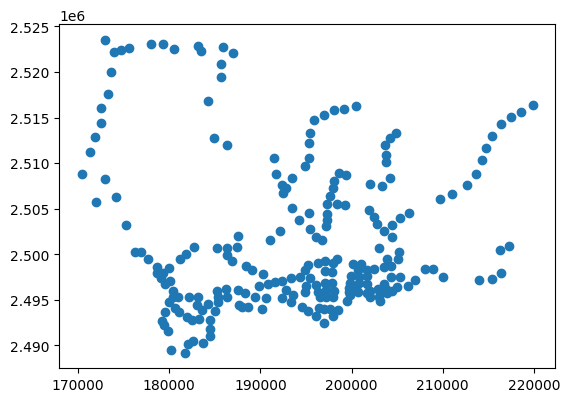

In [67]:
subway.plot()

In [84]:
# create the buffer of the city grid with radius 1000 meters
city_grid_buffer = gpd.GeoDataFrame(city_grid_with_LU.drop(columns=['geometry']), geometry=city_grid_with_LU.to_crs("EPSG:32650").buffer(1000))
# check whether the subway stations are within the buffer and identify these grid with True 
ans = gpd.sjoin(city_grid_buffer, subway, how='left', predicate='contains')
city_grid_with_LU['subway'] = ans.groupby('fnid')['name'].agg(lambda g: ~(g.isna().sum()).astype(bool)).reset_index(drop=True)

In [89]:
old_BE = pd.read_csv('./data/old_BE_varis.csv')
old_BE = old_BE[['fnid', 'density', 'intersections', 'road_density', 'rent']]

In [90]:
city_grid_with_LU = pd.merge(city_grid_with_LU, old_BE, how='left', on='fnid')
city_grid_with_LU['subway'] = city_grid_with_LU['subway'].astype(float)

In [95]:
city_grid_with_LU.head()

,fnid,chess_x,chess_y,geometry,LU_Business,LU_Green,LU_Industry,LU_Public,LU_Residence,subway,density,intersections,road_density,rent
0,413,56,1,"POLYGON ((113.88582 22.44962, 113.88582 22.451...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.28075
1,665,308,1,"POLYGON ((114.50078 22.44962, 114.50078 22.451...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000
2,666,309,1,"POLYGON ((114.50322 22.44962, 114.50322 22.451...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000
3,667,310,1,"POLYGON ((114.50566 22.44962, 114.50566 22.451...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000
4,668,311,1,"POLYGON ((114.50810 22.44962, 114.50810 22.451...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000


## Create the chain feature set

In [97]:
featureset = pd.merge(act_match.drop(columns=['chess_x', 'chess_y']), city_grid_with_LU, how='left', on='fnid')

In [98]:
featureset.drop(columns=['geometry'], inplace=True)

In [100]:
featureset.to_csv(writepath + 'featureset.csv', index=False)

In [101]:
be = pd.read_csv(readpath + 'featureset.csv')

In [102]:
be.rename(columns={'pid': 'who'}, inplace=True)
be = be.assign(t_start = pd.to_datetime(be['t_start']),
          t_end = pd.to_datetime(be['t_end']))

In [103]:
be['date'] = be.t_start.dt.date

In [104]:
be = be.groupby(['who', 'date'], as_index=False).apply(lambda df: df.sort_values('t_start'))
be['seiqd'] = be.groupby(['who', 'date']).cumcount()
be.reset_index(drop=True)

,who,t_start,t_end,poi_id,longitude,latitude,X,Y,ptype,fnid,...,LU_Industry,LU_Public,LU_Residence,subway,density,intersections,road_density,rent,date,seiqd
0,1102234,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,194414.951879,2.507883e+06,1,32600,...,0.237189,0.276817,1.502090,1.0,2.244517,19.555556,22.083556,4.052042,2023-03-01,0
1,1102234,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,197403.987064,2.512234e+06,2,39038,...,1.212193,0.034514,0.146252,0.0,1.183977,16.000000,21.658667,4.864120,2023-03-01,1
2,1102234,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,194911.187574,2.508235e+06,0,33316,...,0.001482,0.117524,0.146829,0.0,29.990070,16.000000,17.516444,3.234051,2023-03-01,2
3,1102234,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,194256.862442,2.508485e+06,0,33671,...,0.000000,0.809837,0.926238,1.0,35.803331,37.333333,32.465778,4.358724,2023-03-02,0
4,1102234,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,197403.987064,2.512234e+06,2,39038,...,1.212193,0.034514,0.146252,0.0,1.183977,16.000000,21.658667,4.864120,2023-03-02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11258,102181433,2023-12-28 00:00:00,2023-12-29 00:00:00,0,113.973390,22.594425,188806.743693,2.501784e+06,1,23653,...,0.000000,1.959859,0.004282,0.0,0.012214,33.777778,34.522667,7.055250,2023-12-28,0
11259,102181433,2023-12-29 00:00:00,2023-12-30 00:00:00,0,113.973390,22.594425,188806.743693,2.501784e+06,1,23653,...,0.000000,1.959859,0.004282,0.0,0.012214,33.777778,34.522667,7.055250,2023-12-29,0
11260,102181433,2023-12-30 00:00:00,2023-12-31 00:00:00,0,113.973390,22.594425,188806.743693,2.501784e+06,1,23653,...,0.000000,1.959859,0.004282,0.0,0.012214,33.777778,34.522667,7.055250,2023-12-30,0
11261,102181433,2023-12-31 00:00:00,2023-12-31 21:31:20,0,113.973390,22.594425,188806.743693,2.501784e+06,1,23653,...,0.000000,1.959859,0.004282,0.0,0.012214,33.777778,34.522667,7.055250,2023-12-31,0


In [106]:
columns = ['who','date', 'seiqd', 't_start', 't_end', 'poi_id', 'longitude', 'latitude', 'X', 'Y',
       'ptype', 'fnid', 'chess_x', 'chess_y', 'LU_Business', 'LU_Green',
       'LU_Industry', 'LU_Public', 'LU_Residence', 'subway', 'density',
       'intersections', 'road_density', 'rent']

be = be.reindex(columns=columns)
# convert the date to integer as %Y%m%d format
be['date'] = be['date'].apply(lambda x: int(x.strftime('%Y%m%d')))

In [108]:
be.to_csv(readpath + 'featureset.csv', index=False)  

---

In [110]:
featureset2 = pd.merge(act_mig_match.drop(columns=['chess_x', 'chess_y']), city_grid_with_LU, how='left', on='fnid')

In [111]:
featureset2.drop(columns=['geometry'], inplace=True)

In [113]:
featureset2.rename({'seq': 'seiqd'}, axis=1, inplace=True)

In [115]:
featureset2.to_csv(writepath + 'featureset2.csv', index=False)

## Sketch Pad